# Slater Koster Tight Binding

This notebook contains the original Slater Koster model, as well as my position based Hamiltonian-Symmetry. It serves as a comparison between the two, as they are quite similar.

In [2]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True)
# finalized libs
from bandstructure import *
from symmetry import *
# not finalized libs
import hamiltonian_symmetry as hsym
import fermi_surface as fs
import kpaths

Symmetries: 48
preparing pseudoinverse
maximal acceleration 1.0
final loss: 1.33e+00 (max band-error [0.698 0.524 0.379 0.485 1.08  0.805 0.658 0.835 1.07  1.179 2.419 2.376])
preparing pseudoinverse
maximal acceleration 8.0
final loss: 9.99e-01 (max band-error [0.784 0.52  0.382 0.643 0.934 0.439 0.927 0.522 1.081 1.391 2.433 1.497])


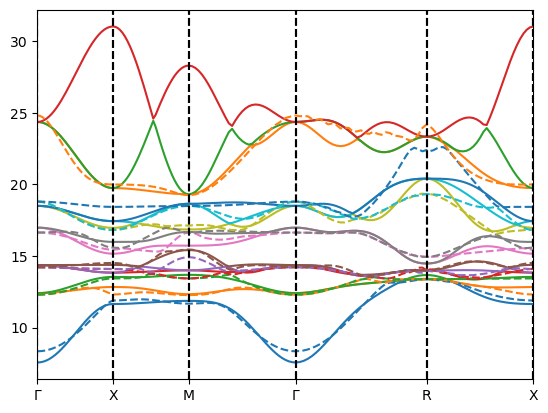

In [3]:
# read the data from Bandx.dat from Quantum Espresso
import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, _, ref_bands, symmetries, fermi_energy = material.read_bands()
print("Symmetries:", len(symmetries))
ref_bands = ref_bands[:,8:]

k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)

hsym_nitinol = hsym.HamiltonianSymmetry(Symmetry.cubic(True))
# TODO look at wannier function to find out which energy belongs to which atom
hsym_nitinol.append_s([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_d2([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_d3([0, 0, 0], "Ni")
hsym_nitinol.append_d2([0, 0, 0], "Ni")
hsym_nitinol.append_d3([0.5, 0.5, 0.5], "Ti")
hsym_nitinol.append_p([0, 0, 0], "Ni")

# now start my algorithm to find good matrices
additional_bands = 2
band_offset = 0 # = additional bands below reference

weights = np.ones(len(ref_bands[0]))
weights[0] = 0.5
weights[-1] = 1.0

neighbors = ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)) # works well
neighbors = Symmetry.cubic(True).complete_neighbors(neighbors)

tb_nitinol = BandStructureModel.init_tight_binding_from_ref(Symmetry.none(), neighbors, k_smpl, ref_bands, band_offset, additional_bands, cos_reduced=False, exp=True)
tb_nitinol.symmetrizer = hsym_nitinol.symmetrizer(neighbors) # for this: cos_reduced=False, exp=True
#tb_nitinol.load("ni_sym.repr")
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 5, 1, train_k0=True, max_accel_global=1.0)
tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 50, 1, train_k0=True, max_accel_global=8.0)
#tb_nitinol.optimize(k_smpl, 1, ref_bands, weights, band_offset, 2000, 4, train_k0=True, regularization=0.999)

#k_smpl, ref_bands = Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.none(), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
#plt.ylim(8, 24)
plt.show()

In [ ]:
tb_nitinol.save("ni_sym.repr")

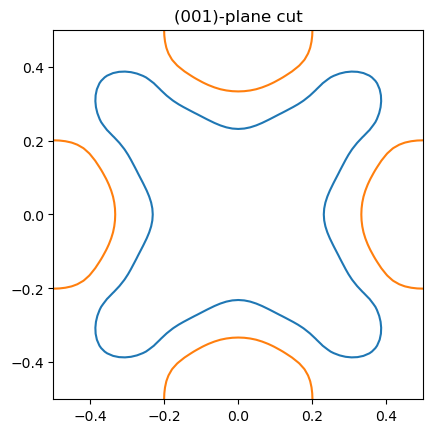

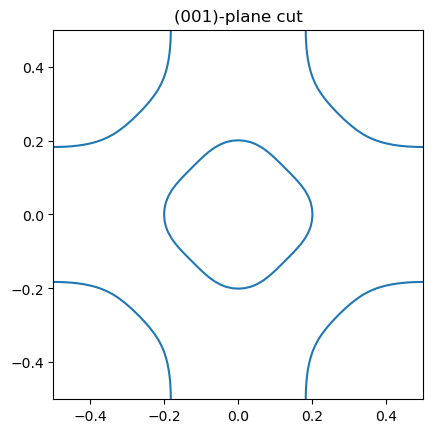

In [28]:
fs.plot_2D_fermi_surface(tb_nitinol, fermi_energy, N=63)

/tmp/ipykernel_229064/2125322718.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
/tmp/ipykernel_229064/2125322718.py:7: RuntimeWarning: invalid value encountered in multiply
  plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
/tmp/ipykernel_229064/2125322718.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
/tmp/ipykernel_229064/2125322718.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))


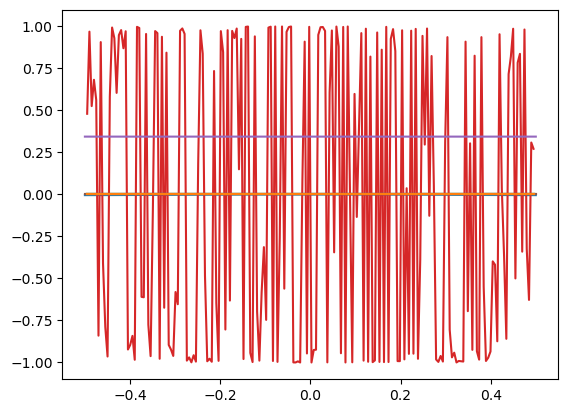

In [4]:
# plot how the unitary rotation matrices behave by plotting
# a few components of the matrices along a k-line
k_x = np.linspace(-0.5, 0.5, 200)
k_line = k_x[:,None] * np.array([[1, 0, 0]]) + np.array([[1, 1, 1]]) * 0.0
Uk = np.linalg.eigh(tb_nitinol.f(k_line))[1]
for i in range(6):
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,1,i] / Uk[:,0,i]))
    plt.plot(k_x, np.abs(Uk[:,0,i]) * np.real(Uk[:,2,i] / Uk[:,0,i]))
plt.show()

In [6]:
np.set_printoptions(precision=2, linewidth=1000)
# compute the inversion symmetry transformation at k=0
Uk1 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, 1e-4]))[1]
Uk2 = np.linalg.eigh(tb_nitinol.f([0.0, 0.0, -1e-4]))[1]
print(np.linalg.eigvals(Uk1 @ np.conj(Uk2.T)))
print(Uk1)

[ 1.  +0.j   -0.38+0.93j  0.97-0.24j -1.  -0.j   -1.  +0.01j -0.72-0.69j  0.69+0.72j -0.3 -0.95j  0.63-0.78j -0.99+0.14j  1.  +0.01j  1.  -0.j    1.  +0.j    1.  -0.07j]
[[ 1.  +0.j   -0.  +0.j   -0.  +0.j    0.  +0.j   -0.  +0.j    0.  +0.j    0.  +0.j   -0.  +0.j   -0.  +0.j   -0.  +0.j   -0.  +0.j    0.  +0.j    0.  +0.j    0.  +0.j  ]
 [ 0.  -0.j    0.06+0.86j  0.17-0.47j -0.  +0.j   -0.  -0.j    0.  -0.j   -0.  +0.j   -0.  -0.j   -0.  -0.j    0.  +0.j    0.  +0.j    0.  -0.j    0.  -0.j   -0.  -0.j  ]
 [-0.  +0.j    0.03+0.5j  -0.3 +0.81j -0.  +0.j   -0.  -0.j    0.  -0.j    0.  -0.j   -0.  -0.j   -0.  -0.j    0.  +0.j    0.  +0.j    0.  -0.j    0.  -0.j    0.  +0.j  ]
 [ 0.  -0.j    0.  -0.j    0.  +0.j    0.  -0.03j -1.  -0.02j -0.  +0.j   -0.  -0.j    0.  -0.j    0.  +0.j    0.01+0.02j -0.  -0.02j -0.  -0.j    0.  +0.j    0.  +0.j  ]
 [-0.  +0.j    0.  -0.j   -0.  +0.j   -0.51-0.86j  0.02-0.02j -0.  -0.j    0.  -0.j   -0.  +0.j    0.  -0.j   -0.  +0.02j -0.01+0.02j -0.  -0.j   